In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-04-20 10:47:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.112, 2404:6800:4004:80c::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   113MB/s    in 1.3s    

2019-04-20 10:47:24 (113 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2019-04-20 10:47:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.31.176, 2404:6800:4004:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.31.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  25.6MB/s    in 0.4s    

2019-04-20 10:47:29 (25.6 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [0]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

We do not explicitly label the images as horses or humans. We'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, we will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/validation-horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/validation-humans')

## Building a Small Model from Scratch

In [0]:
import tensorflow as tf

In [6]:
# Note the input shape is the desired size of the image 150x150 with 3 bytes color
model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),
                tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),
                # Flatten the results to feed into a DNN
                tf.keras.layers.Flatten(),
                # 512 neuron hidden layer
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flat

The "output shape" column shows how the size of our feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

We'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid and use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

We will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
# All images will be resized to 150x150
train_generator = train_datagen.flow_from_directory(
                                '/tmp/horse-or-human/',  
                                target_size=(150, 150),
                                batch_size=128,
                                class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
# All images will be resized to 150x150
validation_generator = validation_datagen.flow_from_directory(
                                        '/tmp/validation-horse-or-human/',  
                                        target_size=(150, 150),  
                                        batch_size=32,
                                        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training

In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=8,  
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
9/9 [==============================] - 6s 690ms/step - loss: 2.0627 - acc: 0.6397 - val_loss: 0.6785 - val_acc: 0.6680
Epoch 2/15
9/9 [==============================] - 6s 657ms/step - loss: 0.5985 - acc: 0.7507 - val_loss: 1.0291 - val_acc: 0.6250
Epoch 3/15
9/9 [==============================] - 6s 658ms/step - loss: 0.1598 - acc: 0.9396 - val_loss: 1.2375 - val_acc: 0.7695
Epoch 4/15
9/9 [==============================] - 6s 648ms/step - loss: 0.0569 - acc: 0.9815 - val_loss: 2.1270 - val_acc: 0.7500
Epoch 5/15
9/9 [==============================] - 6s 673ms/step - loss: 0.3580 - acc: 0.8695 - val_loss: 1.2018 - val_acc: 0.7656
Epoch 6/15
9/9 [==============================] - 6s 652ms/step - loss: 0.0943 - acc: 0.9649 - val_loss: 3.1298 - val_acc: 0.6641
Epoch 7/15
9/9 [==============================] - 6s 650ms/step - loss: 0.0770 - acc: 0.9757 - val_loss: 1.5277 - val_acc: 0.8008
Epoch 8/15
9/9 [==========================

### Running the Model

Even though our model is overfitting the data, let's now take a look at actually running a prediction using the model.

In [0]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

### Visualizing Intermediate Representations

Let's define a new Model that will take an image as input, and will output intermediate representations for all layers in the previous model after the first.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


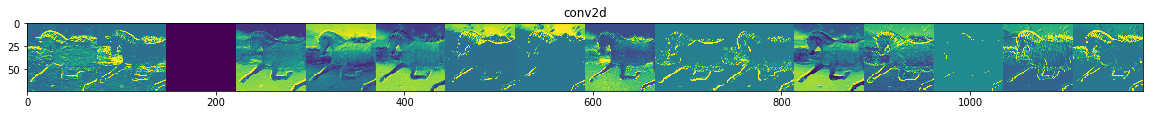

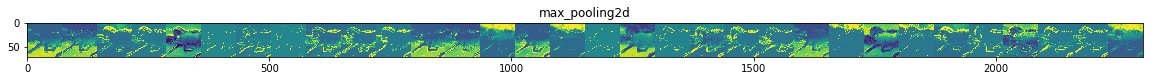

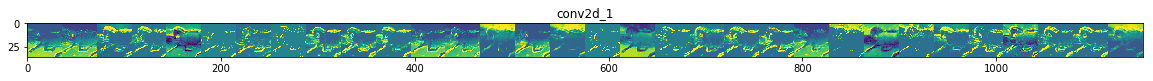

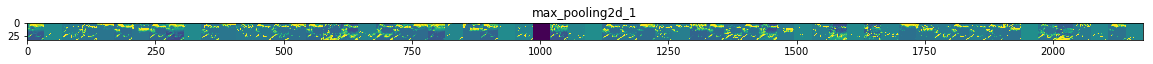

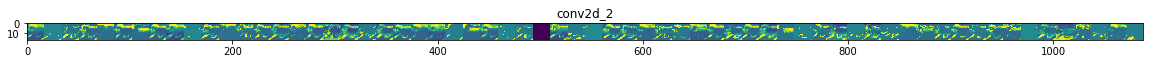

In [15]:
import random
import matplotlib.pyplot as plt

train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)


outputs = [layer.output for layer in model.layers[1:]]
visual_model = tf.keras.models.Model(inputs=model.input, outputs=outputs)

# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = image.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = image.img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, obtaining all
# intermediate representations for this image.
feature_maps = visual_model.predict(x)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
            
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.